# Spoken Digit Dataset
In this notebook, we will develop two deep learning models for speech recognition. More specifically, we will develop Recurrent Neural Network using pytorch. We will use the Free Spoken Digit Dataset which contains about 3000 recordings (50 of each digit per speaker) as .wav files with 8kH sampling rate. First, we import all the necessary libraries.

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import itertools

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch import optim
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We developed some utility functions for data preparation. We use librosa to read the audio files. Then we extract the Mel-Frequency Cepstral Coefficients choosing 13 coefficients that collectively make up an Mel Frequency Cepstrum and those coefficients will be our feature vectors for this problem. Moreover we apply standard scaler to those features, their mean value equals to zero and their standard deviation equals to 1. The name of each file of the dataset is the concatenation of the digit label, the speaker's name and an index. The dataset was splitted to train and test dataset according to the indices of each file. For the training of our models we will use GPU.

In [2]:

def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split("/")[-1].split(".")[0].split('_') for f in files]
    ids = [f[2] for f in fnames]

    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers

def extract_features(wavs, n_mfcc=13, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        librosa.feature.mfcc(
            y=wav, sr=Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T

        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    # Standardize on train data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))
    def scale(X):
        scaled = []

        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled
    return scale


def parser(directory, n_mfcc=13):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

concat_y = lambda x: np.concatenate(x, axis=0)

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dir="../input/free-spoken-digit-dataset-fsdd/recordings/"
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(input_dir)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)
scale_fn = make_scale_fn(X_train + X_val + X_test)
# print("If using X_train + X_dev to calculate normalization statistics")
# scale_fn = make_scale_fn(X_train + X_val)
# print("If using X_train to calculate normalization statistics")
# scale_fn = make_scale_fn(X_train)
X_train = scale_fn(X_train)
X_val = scale_fn(X_val)
X_test = scale_fn(X_test)

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:21<00:00, 138.50it/s]


Feature extraction completed with 13 mfccs per frame
Splitting in train test split using the default dataset split
Normalization will be performed using mean: [-517.82970106   62.38579551   18.81777178    9.58994407  -19.21332917
  -10.90544171  -14.32953791   -7.70082975  -11.9815091    -4.09510747
   -6.72433203   -4.38063522   -7.00035061]
Normalization will be performed using std: [152.29960087  51.9870583   36.7192911   29.63888662  24.80403284
  23.39483934  18.69227569  18.25210438  15.8170314   13.15260358
  14.74107751  12.57444816  11.90043943]


We will examine the MFCC of the first example.

The shape of the spectrogram is 39 x 13


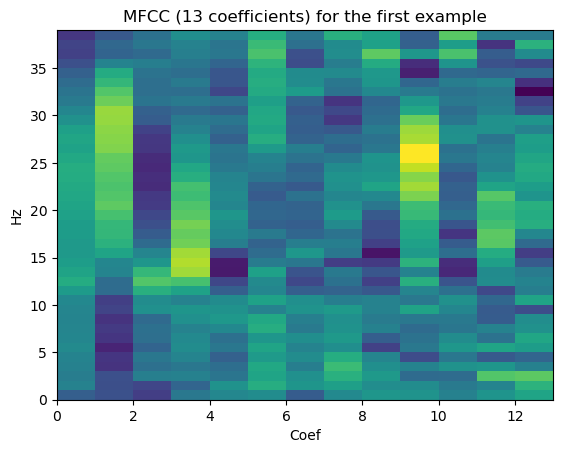

In [4]:
example = X_train[0]
n_mfcc = example.shape[1]
plt.pcolormesh(np.arange(0,example.shape[1]+1),np.arange(0,example.shape[0]+1),example)
plt.title("MFCC (13 coefficients) for the first example")
plt.ylabel("Hz")
plt.xlabel("Coef")
print("The shape of the spectrogram is {} x {}".format(example.shape[0], example.shape[1]))

We develop a Dataset pytorch class in order to prepare the MFCCs for training our Neural Networks. The MFCC of each audio sample has different dimensions. Their second dimension is 13, but the first dimension varies and it is related to the duration of the original audio signal considering that the window and the hop length of the FFT was the same for all the samples. The window was applied to each samples and a different number of windows was generated for each sample, althout 13 coefficients were computer for each window. For that reason, it is important to apply padding to the training data, so all the training data have the same shape.

In [5]:
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths =  [len(f) for f in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        max_length = max(self.lengths)
        padded = np.array([np.pad(example, ((0, max_length - len(example)),(0,0))) for example in x])
        
        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

For this classification task we will use a bidirectional LSTM. The LSTM model consists of an LSTM layer followed by a fully connected linear layer. LSTMs are a special kind of RNN, capable of learning long-term dependencies that are designed to avoid the long term dependency problem. Recurrent neural networks have the form of a chain of repeating modules of neural network.The LSTM has different structure of those repeating modules, and does have the ability to remove or add information to the cell state, carefully regulated by structures called gates. An LSTM has three of these gates, to protect and control the cell state.

In [6]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, dropout=0):
        super(BidirectionalLSTM, self).__init__()
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers,
                            bidirectional= True, batch_first=True, dropout = self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)

            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, True))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        forward, backward = self.split_directions(outputs)
        last_forward = self.last_by_index(forward, lengths)
        last_backward = backward[:, 0, :]
        return torch.cat((last_forward, last_backward), dim=-1)


    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

We initialize the dataset and the dataloaders for model training.

In [7]:
train_dataset = FrameLevelDataset(X_train, y_train)
val_dataset = FrameLevelDataset(X_val, y_val)
test_dataset = FrameLevelDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True, num_workers = 1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True, num_workers = 1)

Next we define some function that will help us train the model. We will use a validation dataset as well to evaluate the model's overfitting during training.

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
def eval_loop(dataloader, model, loss_function):
    model.eval()
    running_loss = 0
    predictions = []
    y_groundtruth = []
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # get the data from batch
            features, labels, lengths = data[0].to(DEVICE), data[1].to(DEVICE), data[2].to(DEVICE)
            # forward pass
            y_preds = model(features, lengths)
            # loss
            loss = loss_function(y_preds, labels)
            # predictions for batch
            predictions_batch = torch.argmax(y_preds, dim=1)
            # append predictions and groundtruth labels of batch
            predictions.append(predictions_batch.cpu().numpy())
            y_groundtruth.append(labels.cpu().numpy())
            # save loss
            running_loss += loss.data.item()
    
    return running_loss / i, (y_groundtruth, predictions)

#train model utilizes training loop and eval loop to train the given model with the given parameters
def train_model(model, epochs, train_dataloader, val_dataloader, loss_function, optimizer):
    training_loss_list = []
    val_loss_list = []
    training_accuracy_list = []
    val_accuracy_list = []
    
    
    for epoch in range(1,epochs+1):
        
        model.train()
        running_loss = 0
        DEVICE = next(model.parameters()).device
        for i, data in enumerate(train_dataloader):
            # get the data from batch
            features, labels, lengths = data[0].to(DEVICE), data[1].to(DEVICE), data[2].to(DEVICE)
            # clear grads
            optimizer.zero_grad()
            # forward pass
            y_preds = model(features, lengths)
            # loss
            loss = loss_function(y_preds, labels)
            # backward pass
            loss.backward()
            # update weights
            optimizer.step()
            # save loss
            running_loss += loss.data.item()

        running_training_loss = running_loss/i

        training_loss, (y_train_groundtruth, train_predictions) = eval_loop(train_dataloader, model, loss_function)
        val_loss, (y_val_groundtruth, val_predictions) = eval_loop(val_dataloader, model, loss_function)
        
        if epoch%10 == 0:
            print("The training loss for epoch {} is {:.5f}".format(epoch, training_loss))
            print("The validation loss for epoch {} is {:.5f}".format(epoch, val_loss))
            print("The training accuracy is for epoch {} is {:.5f}"
                  .format(epoch, accuracy_score(concat_y(y_train_groundtruth),concat_y(train_predictions))))
            print("The validation accuracy is for epoch {} is {:.5f}"
                  .format(epoch, accuracy_score(concat_y(y_val_groundtruth),concat_y(val_predictions))))
        training_loss_list.append(training_loss)
        val_loss_list.append(val_loss)
        training_accuracy_list.append(accuracy_score(concat_y(y_train_groundtruth),concat_y(train_predictions)))
        val_accuracy_list.append(accuracy_score(concat_y(y_val_groundtruth),concat_y(val_predictions)))
        

    
    print("Final Training Loss at Epoch {} is {:.5f}".format(epoch, training_loss))
    print("Final Validation Loss at Epoch {} is {:.5f}".format(epoch, val_loss))
    
    return training_loss_list, val_loss_list, training_accuracy_list, val_accuracy_list




The LSTM Layer has 16 cells. We will use Cross Entropy Loss as the loss function, and Adam as the optimizer with initial learning rate 0.001 and weight decay 0.00005.

In [9]:
rnn_size = 32
epochs = 32
modelLSTM = BidirectionalLSTM(input_dim = n_mfcc, rnn_size = rnn_size, output_dim=10, num_layers=1, 
                              dropout=0.2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelLSTM.parameters(), lr=1e-3, weight_decay = 5e-5)

train_loss_LSTM, val_loss_LSTM, train_acc_LSTM, val_acc_LSTM = train_model(modelLSTM, 
                                                                           epochs, 
                                                                           train_dataloader, 
                                                                           val_dataloader, 
                                                                           loss_function, optimizer)

The training loss for epoch 10 is 0.06356
The validation loss for epoch 10 is 0.11649
The training accuracy is for epoch 10 is 0.99259
The validation accuracy is for epoch 10 is 0.97407
The training loss for epoch 20 is 0.01953
The validation loss for epoch 20 is 0.06017
The training accuracy is for epoch 20 is 0.99815
The validation accuracy is for epoch 20 is 0.98519
The training loss for epoch 30 is 0.00867
The validation loss for epoch 30 is 0.05201
The training accuracy is for epoch 30 is 0.99861
The validation accuracy is for epoch 30 is 0.98704
Final Training Loss at Epoch 32 is 0.00766
Final Validation Loss at Epoch 32 is 0.06425


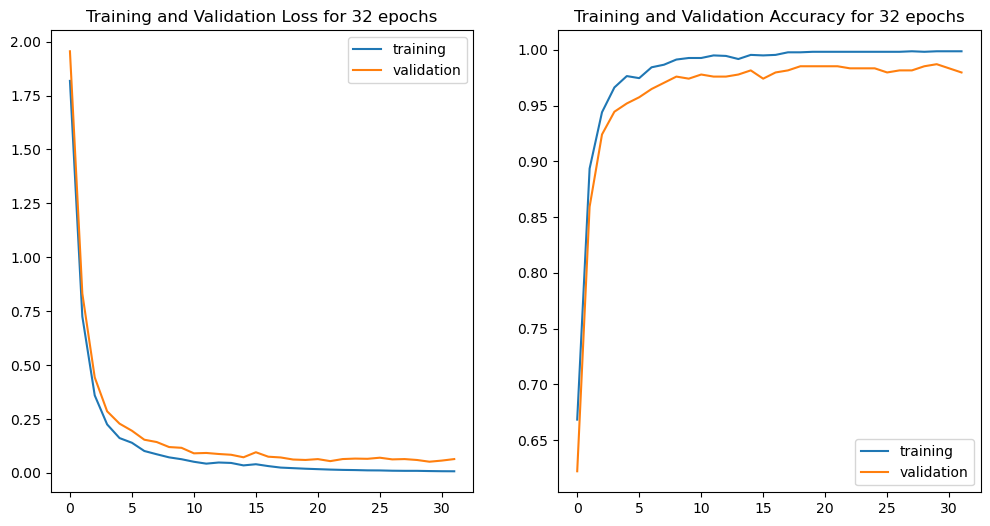

In [10]:
#Plot the Loss and Accuracy (training and validation) for Chromagram dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set(title='Training and Validation Loss for 32 epochs')
ax1.plot(np.arange(len(train_loss_LSTM)),train_loss_LSTM, label = "training")
ax1.plot(np.arange(len(val_loss_LSTM)),val_loss_LSTM, label = "validation")
ax1.legend()
ax2.set(title='Training and Validation Accuracy for 32 epochs')
ax2.plot(np.arange(len(train_acc_LSTM)),train_acc_LSTM, label = "training")
ax2.plot(np.arange(len(val_acc_LSTM)),val_acc_LSTM, label = "validation")
ax2.legend()

We trained the model for 32 epoches and achienved 0.99 training accuracy and 0.98 validation accuracy. From the figures above we can see that the validation loss is remains almost equal to the training loss during the training which means that our LSTM is robust to overfitting. In order to evaluate further our model we will use classification report provided by scikit learn and will use the test dataset. Parameters of evaluation is overall accuracy, precision, recall and f1-score. Precision is the actual correct predictions divided by total predictions made by the model. Recall is defind by dividing the number of true positives by the sum of the number of the true positives and the false negatives. F1-score is the harmonic mean between precision and recall. Moreover we will use a confusion matrix to examine which digits were recognised better.

In [11]:
def evaluate_model(model, dataloader, loss_function, model_title):
    
    def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        plt.figure(figsize=(8,8))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
    
    loss, (y_groundtruth, predictions) = eval_loop(dataloader, model, loss_function)
    print("The classification report for the "+model_title)
    print(classification_report(concat_y(y_groundtruth),concat_y(predictions)))
    
    cm = np.zeros((10,10))
    for i in range(len(y_groundtruth)):
        cm[y_groundtruth[i], predictions[i]]+=1
    
    plot_confusion_matrix(cm, range(10), normalize=True)

The classification report for the Bidirectional LSTM
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        30
           2       1.00      0.97      0.98        30
           3       0.97      1.00      0.98        30
           4       0.97      1.00      0.98        30
           5       1.00      1.00      1.00        30
           6       0.94      0.97      0.95        30
           7       1.00      1.00      1.00        30
           8       0.97      0.93      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Normalized confusion matrix


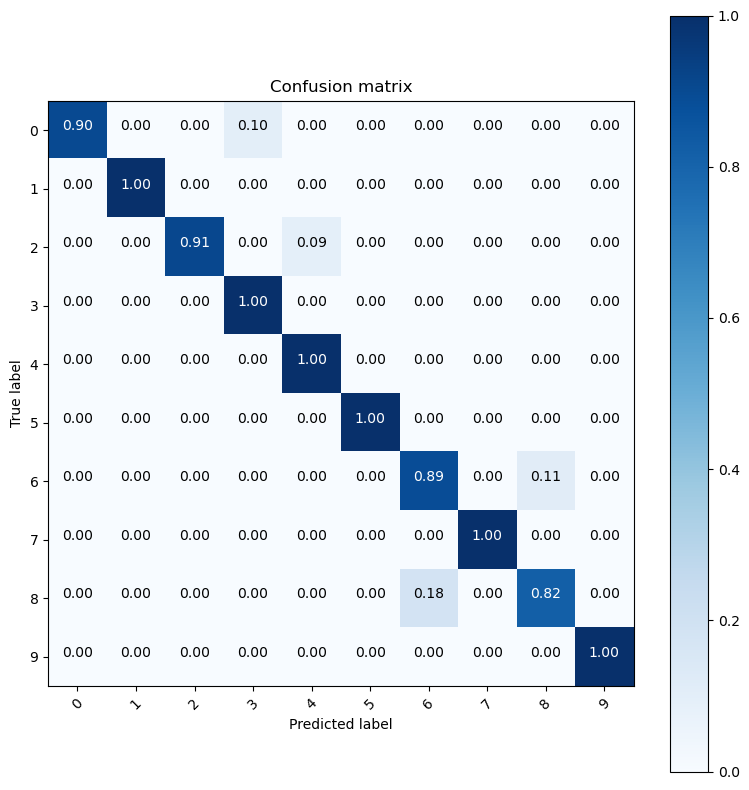

In [12]:
evaluate_model(modelLSTM, test_dataloader, loss_function, model_title="Bidirectional LSTM")

We have achieved 0.98 for the test dataset as well and really good results for precision, recall and f1-score considering that their values are above 0.90 (most of them are really 1). Although, by observing the consfusion matrix we can see that our model made some false predictions for the digits 6 and 8.

### References
<ol>
  <li>R. O. Duda, P.E. Hart and D.G. Stork, Pattern Classification, Wiley, 2001</li>
  <li>C. M. Bishop, Pattern Recognition and Machine Learning, Springer, 2006</li>
  <li>https://colah.github.io/posts/2015-08-Understanding-LSTMs/</li>
</ol> 